## Google Collab

In [1]:
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h
!lscpu |grep 'Thread(s) per core'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Core(s) per socket:  1
              total        used        free      shared  buff/cache   available
Mem:            12G        617M         10G        1.2M        1.9G         11G
Swap:            0B          0B          0B
Thread(s) per core:  2


In [2]:
# Mount Google Drive and load project 2
# WARNING, we have to add the shared drive of Sami on our home directory (by creating an alias)
from google.colab import drive
drive.mount('/content/drive')
#Move to the shared directory
%cd /content/drive/MyDrive/ml_project_2_drive/ml_project_2/
# list all files
! ls

# Read helpers python file
!cp /content/drive/MyDrive/ml_project_2_drive/ml_project_2/script/helper_functions.py .

# A good help can be found here:
#https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1vl5CPcw7JK4DNIOpS5Vo_q-TUsJxR6Us/ml_project_2_drive/ml_project_2
checkpoint		  README.md
data			  road_segmentation_etienne.ipynb
helper_functions.py	  road_segmentation_sami.ipynb
project2_description.pdf  script


In [3]:
!git config --global user.email "etienne.bruno@epfl.ch"
!git config --global user.name "Etienne BRUNO"

In [ ]:
!git pull

In [ ]:
!git add .
!git commit -m "update from google colab"
!git push

## library

In [ ]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def load_train_dataset():
    root_dir = "/"
    image_dir = root_dir + "images/"
    gt_dir = root_dir + "groundtruth/"
    files = os.listdir(image_dir)
    n = len(files)

    np_X = [load_image(image_dir + files[i]) for i in range(n)]
    np_Y = [load_image(gt_dir + files[i]) for i in range(n)]

    torch_X = [torch.from_numpy(x).reshape(3, 400, 400) for x in np_X]
    torch_Y =[torch.from_numpy(y).reshape(1, 400, 400) for y in np_Y]

    return (torch_X, torch_Y)

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state:            checkpoint we want to save
    is_best:          boolean to indicates if it is the best checkpoint
    checkpoint_path:  path to save checkpoint
    best_model_path:  path to save best model
    """
    f_path = checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

## Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import random
import os,sys
from PIL import Image
import torchvision.transforms as T
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#from helper_functions import *

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Constants definition

In [ ]:
CHECKPOINT_PATH =""
BEST_MODEL_PATH =""
NBR_EPOCHS = 15
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
GAMMA = 1
K_FOLD = 4
VALIDATION_SET_IDX = 0
BATCH_SIZE_VAL = 5
SEED = 0

## Data set

In [ ]:
class imagesDataset(Dataset): 
    def __init__(self, K_fold, validation_set_idx, batch_size_val, seed):
        X, Y = load_train_dataset()

        #tresholding ground_truth values
        Y = [(y > 0.5).long() for y in Y]
        shape_y = Y[0].shape
        
        #shuffling
        random.seed(seed)
        idx_list = list(range(len(X)))
        random.shuffle(idx_list)
        random.seed()
        X = [X[idx] for idx in idx_list]
        Y = [Y[idx] for idx in idx_list]
        
        #K_fold separation
        fold_size = len(X) // K_fold
        start_validation_idx = validation_set_idx * fold_size
        end_validation_idx = start_validation_idx + fold_size
        self.X_train = X[slice(0, start_validation_idx)] + X[slice(end_validation_idx, None)]
        self.Y_train = Y[slice(0, start_validation_idx)] + Y[slice(end_validation_idx, None)]
        self.X_validation = X[slice(start_validation_idx, end_validation_idx)]
        self.Y_validation = Y[slice(start_validation_idx, end_validation_idx)]

        #data augmentation
        #self.X_train = compose_all_functions_for_data(self.X_train)
        #self.Y_train = compose_all_functions_for_data(self.Y_train)
        #self.X_validation = compose_all_functions_for_data(self.X_validation)
        #self.Y_validation = compose_all_functions_for_data(self.Y_validation)
        self.n_samples = len(self.X_train)
        
        #casting into tensors
        self.X_train = torch.stack(self.X_train)
        self.X_validation = torch.stack(self.X_validation)
        self.Y_train = torch.reshape(torch.stack(self.Y_train) , (-1, shape_y[1], shape_y[2]))
        self.Y_validation = torch.reshape(torch.stack(self.Y_validation) , (-1, shape_y[1], shape_y[2]))

        #creating dataloader for validation data
        class dataset_validation(Dataset):
            def __init__(s,x,y):
                s.x = x
                s.y = y
                s.size = len(s.x)
            def __getitem__(s, index):
                return s.x[index], s.y[index]
            def __len__(s):
                return s.size
               
        self.validation_data_loader = torch.utils.data.DataLoader(
            dataset_validation(self.X_validation, self.Y_validation),
            batch_size = batch_size_val, shuffle = False)
        
        
    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]

    def __len__(self):
        return self.n_samples
    
    def get_validation_dataloader(self):
        return self.validation_data_loader


dataset = imagesDataset(K_FOLD, VALIDATION_SET_IDX, BATCH_SIZE_VAL, SEED)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = dataset.get_validation_dataloader()

## Model

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # 
        self.pool_d = nn.MaxPool2d(2, 2)
        self.pool_u = nn.Upsample(scale_factor=2)
        
        # Activation function
        #self.activ = nn.ReLU()
        self.activ = nn.LeakyReLU(0.1)
        
        # Convolution Downwards
        self.conv_1 = nn.Conv2d(3, 64, (3,3), padding=(1, 1))
        self.conv_2 = nn.Conv2d(64, 64, (3,3), padding=(1, 1))
        
        self.conv_3 = nn.Conv2d(64, 128, (3,3), padding=(1, 1))
        self.conv_4 = nn.Conv2d(128, 128, (3,3), padding=(1, 1))
        
        self.conv_5 = nn.Conv2d(128, 256, (3,3), padding=(1, 1))
        self.conv_6 = nn.Conv2d(256, 256, (3,3), padding=(1, 1))
        
        self.conv_7 = nn.Conv2d(256, 512, (3,3), padding=(1, 1))
        self.conv_8 = nn.Conv2d(512, 512, (3,3), padding=(1, 1))
        
        self.conv_9 = nn.Conv2d(512, 1024, (3,3), padding=(1, 1))
        self.conv_10 = nn.Conv2d(1024, 1024, (3,3), padding=(1, 1))
        
        
        # Upconvolution
        self.upconv_1 = nn.Conv2d(512+1024, 512, (3,3), padding=(1, 1))
        self.upconv_2 = nn.Conv2d(512, 512, (3,3), padding=(1, 1))
        
        self.upconv_3 = nn.Conv2d(256+512, 256, (3,3), padding=(1, 1))
        self.upconv_4 = nn.Conv2d(256, 256, (3,3), padding=(1, 1))
        
        self.upconv_5 = nn.Conv2d(128+256, 128, (3,3), padding=(1, 1))
        self.upconv_6 = nn.Conv2d(128, 128, (3,3), padding=(1, 1))
        
        self.upconv_7 = nn.Conv2d(64+128, 64, (3,3), padding=(1, 1))
        self.upconv_8 = nn.Conv2d(64, 64, (3,3), padding=(1, 1))
        self.upconv_9 = nn.Conv2d(64, 2, (1,1))


    def forward(self, x):
        # Convolution with activation and max_pooling
        xd_1 = self.activ(self.conv_1(x))
        xd_2 = self.activ(self.conv_2(xd_1))
    
        xd_3 = self.activ(self.conv_3(self.pool_d(xd_2)))
        xd_4 = self.activ(self.conv_4(xd_3))
        
        xd_5 = self.activ(self.conv_5(self.pool_d(xd_4)))
        xd_6 = self.activ(self.conv_6(xd_5))
        
        xd_7 = self.activ(self.conv_7(self.pool_d(xd_6)))
        xd_8 = self.activ(self.conv_8(xd_7))
        
        xd_9 = self.activ(self.conv_9(self.pool_d(xd_8)))
        xd_10 = self.pool_u(self.activ(self.conv_10(xd_9)))

        # "Fractionally / Backward strided convolution" with activation and upsampling
        xu_1 = self.activ(self.upconv_1(torch.cat((xd_8, xd_10), dim=1)))
        xu_2 = self.pool_u(self.activ(self.upconv_2(xu_1)))
        
        xu_3 = self.activ(self.upconv_3(torch.cat((xd_6, xu_2), dim=1)))
        xu_4 = self.pool_u(self.activ(self.upconv_4(xu_3)))
        
        xu_5 = self.activ(self.upconv_5(torch.cat((xd_4, xu_4), dim=1)))
        xu_6 = self.pool_u(self.activ(self.upconv_6(xu_5)))
        
        xu_7 = self.activ(self.upconv_7(torch.cat((xd_2, xu_6), dim=1)))
        xu_8 = self.activ(self.upconv_8(xu_7))
        xu_9 = self.upconv_9(xu_8)
    
        return xu_9

###################################################################################################################################
###################################################################################################################################

class ConvNet_not_recurrent(nn.Module):
    def __init__(self):
        super(ConvNet_not_recurrent, self).__init__()
        self.pool_d = nn.MaxPool2d(2, 2)
        self.pool_u = nn.Upsample(scale_factor=2)
        
        # Activation function
        self.activ = nn.ReLU()
        #self.activ = nn.LeakyReLU(0.1)
        
        # Convolution Downwards
        self.conv_1 = nn.Conv2d(3, 64, (3,3), padding=(1, 1))
        self.conv_2 = nn.Conv2d(64, 64, (3,3), padding=(1, 1))
        
        self.conv_3 = nn.Conv2d(64, 128, (3,3), padding=(1, 1))
        self.conv_4 = nn.Conv2d(128, 128, (3,3), padding=(1, 1))
        
        self.conv_5 = nn.Conv2d(128, 256, (3,3), padding=(1, 1))
        self.conv_6 = nn.Conv2d(256, 256, (3,3), padding=(1, 1))
        
        self.conv_7 = nn.Conv2d(256, 512, (3,3), padding=(1, 1))
        self.conv_8 = nn.Conv2d(512, 512, (3,3), padding=(1, 1))
        
        self.conv_9 = nn.Conv2d(512, 1024, (3,3), padding=(1, 1))
        self.conv_10 = nn.Conv2d(1024, 1024, (3,3), padding=(1, 1))
        
        
        # Upconvolution
        self.upconv_1 = nn.Conv2d(1024, 512, (3,3), padding=(1, 1))
        self.upconv_2 = nn.Conv2d(512, 512, (3,3), padding=(1, 1))
        
        self.upconv_3 = nn.Conv2d(512, 256, (3,3), padding=(1, 1))
        self.upconv_4 = nn.Conv2d(256, 256, (3,3), padding=(1, 1))
        
        self.upconv_5 = nn.Conv2d(256, 128, (3,3), padding=(1, 1))
        self.upconv_6 = nn.Conv2d(128, 128, (3,3), padding=(1, 1))
        
        self.upconv_7 = nn.Conv2d(128, 64, (3,3), padding=(1, 1))
        self.upconv_8 = nn.Conv2d(64, 64, (3,3), padding=(1, 1))
        self.upconv_9 = nn.Conv2d(64, 2, (1,1))



    def forward(self, x):
        # Convolution with activation and max_pooling
        xd_1 = self.activ(self.conv_1(x))
        xd_2 = self.activ(self.conv_2(xd_1))
    
        xd_3 = self.activ(self.conv_3(self.pool_d(xd_2)))
        xd_4 = self.activ(self.conv_4(xd_3))
        
        xd_5 = self.activ(self.conv_5(self.pool_d(xd_4)))
        xd_6 = self.activ(self.conv_6(xd_5))
        
        xd_7 = self.activ(self.conv_7(self.pool_d(xd_6)))
        xd_8 = self.activ(self.conv_8(xd_7))
        
        xd_9 = self.activ(self.conv_9(self.pool_d(xd_8)))
        xd_10 = self.pool_u(self.activ(self.conv_10(xd_9)))

        # "Fractionally / Backward strided convolution" with activation and upsampling
        xu_1 = self.activ(self.upconv_1(xd_10))
        xu_2 = self.pool_u(self.activ(self.upconv_2(xu_1)))
        
        xu_3 = self.activ(self.upconv_3(xu_2))
        xu_4 = self.pool_u(self.activ(self.upconv_4(xu_3)))
        
        xu_5 = self.activ(self.upconv_5(xu_4))
        xu_6 = self.pool_u(self.activ(self.upconv_6(xu_5)))
        
        xu_7 = self.activ(self.upconv_7(xu_6))
        xu_8 = self.activ(self.upconv_8(xu_7))
        xu_9 = self.upconv_9(xu_8)
        return xu_9


## Training

In [ ]:
def train(n_epochs, data_loader, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path):
    train_loader = data_loader
    validation_loader = train_loader.dataset.get_validation_dataloader()
    f1_max = 0
    
    for epoch in range(n_epochs):
        loss_list = []
        model.train()
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        loss_epoch = np.mean(loss_list)

        model.eval()
        #computing F1 score on validation data
        tp, fp, fn = 0, 0, 0
        for (data, target) in validation_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            prediction = torch.argmax(output, dim = 1)
            confusions = prediction / target
            tp += torch.sum(confusions == 1).item()
            fp += torch.sum(confusions == float('inf')).item()
            fn += torch.sum(confusions == 0).item()
        f1_score_val = 2 * tp / (2 * tp + fp + fn)
        
        if f1_score_val > f1_max:
            torch.save(model.state_dict(), best_model_path)
            f1_max = f1_score_val

        checkpoint = {
            'epoch': epoch,
            'f1_max': f1_max,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.get_last_lr(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        #computing F1 score on training data
        tp, fp, fn = 0, 0, 0
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            prediction = torch.argmax(output, dim = 1)
            confusions = prediction / target
            tp += torch.sum(confusions == 1).item()
            fp += torch.sum(confusions == float('inf')).item()
            fn += torch.sum(confusions == 0).item()
        f1_score_train = 2 * tp / (2 * tp + fp + fn)

        print(f"Epoch {epoch} || Loss:{loss_epoch:.6f} || Training F1 {f1_score_train:.6f}|| Validation F1 {f1_score_val:.6f} || Learning rate {scheduler.get_last_lr()[0]:.6f}"+"\n")  
        scheduler.step()
        
    return 

In [ ]:
LOAD_LAST_CHECKPOINT = False
LOAD_BEST_MODEL = False

#model = ConvNet().to(device)
model = ConvNet_not_recurrent().to(device)

if LOAD_LAST_CHECKPOINT and not LOAD_BEST_MODEL:
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['state_dict'])
    
if not LOAD_LAST_CHECKPOINT and LOAD_BEST_MODEL:
    model.load_state_dict(torch.load(BEST_MODEL_PATH))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()

KeyboardInterrupt: ignored

In [ ]:
#train(NBR_EPOCHS, train_loader, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH)

# Debugging

In [ ]:
def train_on_single_sample(n_epochs, im_test, gt_test, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path):
    for epoch in range(n_epochs):
        data, target = im_test.to(device), gt_test.to(device)

        model.train()
        # Evaluate the network (forward pass)
        output = model(data)
        loss = criterion(output, target)

        # Compute the gradient
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()

        #computing prediction to judge the model
        prediction = torch.argmax(output, dim = 1)

        #computing F1 score
        model.eval()
        tp, fp, fn = 0, 0, 0
        confusions = prediction / target
        tp += torch.sum(confusions == 1).item()
        fp += torch.sum(confusions == float('inf')).item()
        fn += torch.sum(confusions == 0).item()
        f1_score = 2 * tp / (2 * tp + fp + fn)
        
        #computing accuracy
        correct_predictions = prediction.eq(target)
        accuracy = correct_predictions.sum().float() / correct_predictions.nelement()
  

        print(f"Epoch {epoch} || Loss:{loss:.6f} || Training F1 {f1_score:.6f} || Training Accuracy : {accuracy}|| Learning rate {scheduler.get_last_lr()[0]:.6f}"+"\n")  
        #scheduler.step()
        
    return 

In [ ]:
#model = ConvNet_not_recurrent().to(device)
model = ConvNet().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()

In [ ]:
im_test, gt_test = next(iter(train_loader))

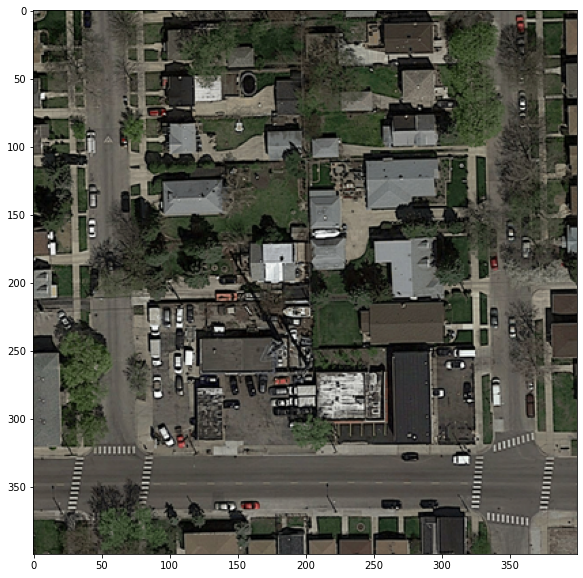

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(im_test, (400, 400, 3)), cmap='Greys_r')

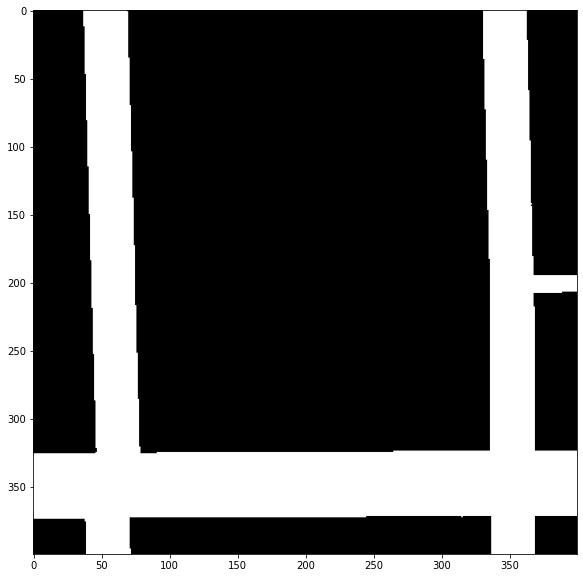

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(gt_test, (400, 400)), cmap='Greys_r')

In [ ]:
train_on_single_sample(NBR_EPOCHS, im_test, gt_test, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH)

Epoch 0 || Loss:0.704422 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 1 || Loss:0.704264 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 2 || Loss:0.704026 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 3 || Loss:0.703750 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 4 || Loss:0.703455 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 5 || Loss:0.703150 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 6 || Loss:0.702842 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 7 || Loss:0.702532 || Training F1 0.418410 || Training Accuracy : 0.26455000042915344|| Learning rate 0.001000

Epoch 8 || Loss:0.702222 || Training F1 0.418410 || Trai